### ConvTasNet evaluation

First, run `CTN_training.py` with desired arguments to create `saved_models` directory with checkpoints and final saved model.
TensorBoard can also be used on the created `runs` directory to monitor training.

This notebook loads a pretrained ConvTasNet for evaluation. Note `model_name_stub` should be redefined to load the selected model.

In [26]:
import os
import torch
import numpy as np
import argparse
import matplotlib.pyplot as plt
from matplotlib import gridspec
from inspect import getmembers, isfunction, isclass
from torch.utils.data import TensorDataset, DataLoader

from splitml import losses
from splitml import activations
from splitml.dualrealconvtasnet import DualRealConvTasNet
from splitml.dualrealchannelsconvtasnet import DualRealChannelsConvTasNet
from splitml.complexconvtasnet import ComplexConvTasNet
from splitml.data import synthetic_data_gen

losses_dict = {k: v for (k, v) in getmembers(losses, isfunction)}
losses_dict['mse'] = torch.nn.MSELoss()
activs_dict = {k: v for (k, v) in getmembers(activations, isclass)}
activs_dict['PReLU'] = torch.nn.PReLU
activs_dict['Sigmoid'] = torch.nn.Sigmoid
models_dict = {'DualRealConvTasNet': DualRealConvTasNet,
                'DualReal2ConvTasNet': DualRealConvTasNet, 
                'DualRealChannelsConvTasNet': DualRealChannelsConvTasNet, 
                'ComplexConvTasNet': ComplexConvTasNet}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nt = 1024

save_folder = 'saved_models'
model_name_stub = 'Nov15'

#### Load saved ConvTasNet model

In [27]:
ckpt_files = os.listdir(save_folder)
file_name = [i for i in ckpt_files if i.startswith(model_name_stub)][0]
c = torch.load('%s/%s' % (save_folder, file_name))
sd = c['net']
args = {k: v for k, v in c.items() if k != 'net'}
args = argparse.Namespace(**args)
model_fn = models_dict[args.model]
seed = args.seed
batch_size = args.batch_size
lr = args.lr
n_epochs = args.n_epochs
loss_fn = losses_dict[args.loss_fn]
# model kwargs
m_kwargs = {}
m_kwargs['enc_kernel_size'] = args.win
m_kwargs['enc_num_feats'] = args.enc_dim
m_kwargs['enc_depth'] = args.enc_depth
m_kwargs['enc_activate'] = activs_dict[args.activ]
m_kwargs['stft_layer'] = args.stft_layer
m_kwargs['msk_kernel_size'] = args.msk_kern_size
m_kwargs['msk_num_feats'] = args.msk_num_feats
m_kwargs['msk_num_hidden_feats'] = args.msk_num_hidden_feats
m_kwargs['msk_num_layers'] = args.msk_num_layers
m_kwargs['msk_num_stacks'] = args.msk_num_stacks
m_kwargs['dc_activ'] = activs_dict[args.dc_activ]
m_kwargs['msk_activate'] = activs_dict[args.msk_activ]
if args.share_encoder is not None:
    m_kwargs['share_encoder'] = args.share_encoder
if args.share_decoder is not None:
    m_kwargs['share_decoder'] = args.share_decoder
if args.share_mask is not None:
    m_kwargs['share_mask'] = args.share_mask

np.random.seed(seed)
torch.manual_seed(seed)

model = model_fn(**m_kwargs).to(device)
model.load_state_dict(sd)
model.eval();
print(args)


Namespace(loss=60.300397872924805, epoch=46, model='DualRealChannelsConvTasNet', seed=42, batch_size=256, lr=0.0003, n_epochs=50, save_folder='saved_models', resume=False, win=128, enc_dim=512, enc_depth=3, stft_layer=False, msk_kern_size=3, msk_num_feats=128, msk_num_hidden_feats=16, msk_num_layers=8, msk_num_stacks=3, high_snr_data=False, central_f_zero=True, use_cuda=False, loss_fn='complex_logmse', activ='PReLU', dc_activ='PReLU', msk_activ='Sigmoid', share_encoder=True, share_decoder=True, share_mask=True)


#### Generate test data

In [28]:
N_signals = 10000 
if args.central_f_zero:
    w_range = [-150, 150]
else:
    w_range = [1450, 1750]
if args.high_snr_data:
    A_range = [2.1, 3]
else:
    A_range = [0.1, 1]
(clean_training, noise_training, clean_validation, noisy_validation, 
    clean_testing, noise_testing, sig_params_training, sig_params_validation, 
    sig_params_testing, t) = synthetic_data_gen(N = N_signals, nt = nt, fs = 1./1.8e-05, 
                            w_range = w_range, phi_range = [-np.pi, np.pi], T2_range = [1e-3, 1e-2], 
                            sigma_range = [1e-3, 1e-2], A_range = A_range, s =1, seed=args.seed)

test_A = sig_params_testing['A'].values
x_test = clean_testing + noise_testing
y_test = np.stack([noise_testing, clean_testing], axis=1)
test_t = TensorDataset(torch.from_numpy(x_test[:, None, :].astype(np.complex64)), 
                        torch.from_numpy(y_test.astype(np.complex64)), torch.from_numpy(test_A[:, None]))
test_loader = DataLoader(test_t, batch_size=batch_size, shuffle=False, drop_last=False)

In [29]:
predictions = []
batch_mse = 0
batch_idx = 0
for x_test, y_test, A_test in test_loader:
    with torch.no_grad():
        yhat = model(x_test.to(device))
        predictions.append(yhat[:, 1, :].detach().cpu().numpy())
        mse = losses_dict['complex_mse'](yhat[:, 1, :]/A_test.to(device), (y_test[:, 1, :]/A_test).to(device))
        batch_mse += mse.item()
        batch_idx += 1
test_mse = batch_mse / batch_idx
predictions = np.concatenate(predictions, 0)

#### View predictions example

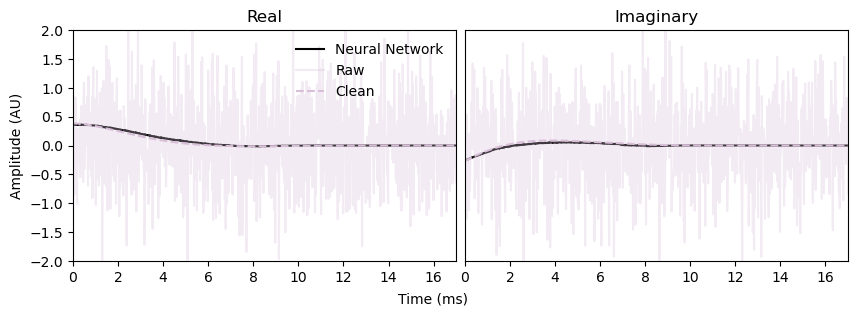

In [30]:
row = 1
### Time Domain Plot ###
fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.023) 
fig.set_size_inches(10,3)
fig.text(0.45, -.03, 'Time (ms)')

# Real component plot
ax1 = plt.subplot(gs[0,0])
plt.plot((t*1000), predictions.real[row,:], label='Neural Network',color = 'black')
plt.plot((t*1000), noise_testing.real[row,:], alpha=0.3, label='Raw',color = 'thistle')
plt.plot((t*1000), clean_testing.real[row,:], label='Clean',color = 'thistle', linestyle='dashed')
plt.ylabel('Amplitude (AU)')
plt.ylim(-2,2)
plt.xlim(0,17)
plt.title('Real')
plt.legend(loc='upper right', frameon=False)

# Imaginary component plot
ax2 = plt.subplot(gs[0,1])
plt.plot((t*1000), predictions.imag[row,:], label='CTN',color = 'black')
plt.plot((t*1000), noise_testing.imag[row,:], alpha=0.3, label='Raw',color = 'thistle')
plt.plot((t*1000), clean_testing.imag[row,:], label='Clean',color = 'thistle', linestyle='dashed')
plt.yticks([])
plt.ylim(-2,2)
plt.xlim(0,17)
plt.title('Imaginary')
plt.show()

#### Calculate $R^2$

In [31]:
# Calculate R^2
z = np.zeros((clean_testing.shape[0], nt),dtype=complex)
z = torch.tensor(z).to(device).type(torch.complex64)
clean_testing_data = torch.tensor(clean_testing).to(device).type(torch.complex64)
# Rescale clean signal
for i in range(len(clean_testing_data)):
    clean_testing_data[i,:] = clean_testing_data[i,:]/torch.tensor(test_A[i]).to(device)
no_sig_mse = losses_dict['complex_mse'](z, clean_testing_data).detach().numpy() # rescaled MSE for no signal prediction
ctn_rsq = (1-test_mse/no_sig_mse)
print('R sqared for CTN is', ctn_rsq)

R sqared for CTN is 0.7960442600805596
